In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Imports
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import gc

In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import R2UNet
from utils import read_tiff, dataset_label_mean, adjusted_mse

In [3]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

TRAIN_IMAGE_PATH = './kidney_dataset/train/2f6ecfcdf.tiff'
TRAIN_LABEL_PATH = './kidney_dataset/train/2f6ecfcdf.json'

test_image = read_tiff(TEST_IMAGE_PATH)
train_image = read_tiff(TRAIN_IMAGE_PATH)

C:\Users\iraha\anaconda3\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


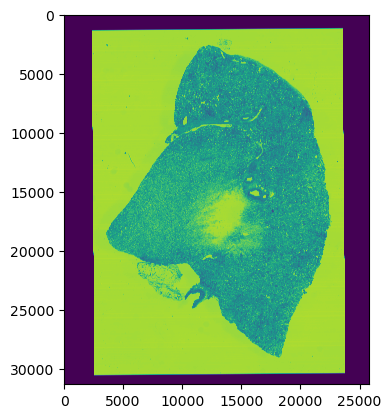

In [4]:
plt.imshow(np.transpose(train_image, (1, 2, 0)))

In [94]:
patch_size = 512
model_resolution = 128
num_train_samples = 1000
num_val_samples = 100
batch_size = 100

dtype = torch.cuda.FloatTensor

In [95]:
train_glomeruli = get_glomeruli(TRAIN_LABEL_PATH,'glomerulus')
val_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')

# Generate patch samples from image
train_patches = generate_glomerulus_patches(
    patch_size = patch_size,
    num_patches = num_train_samples,
    glomeruli = train_glomeruli,
    image = train_image
)

val_patches = generate_glomerulus_patches(
    patch_size = patch_size,
    num_patches = num_val_samples,
    glomeruli = val_glomeruli,
    image = test_image
)

train_dataset = KidneySampleDataset(train_patches)
val_dataset = KidneySampleDataset(val_patches)

# Calculate dataset mean
# label_mean = dataset_label_mean(train_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [96]:
model = R2UNet((model_resolution, model_resolution), (patch_size, patch_size)).cuda()

In [97]:
def dice_loss(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = 1 - (2 * intersection) / (union + intersection)
    return dice

def train(model, label_mean, epochs=100):
    gc.collect()
    torch.cuda.empty_cache()
    
    best_weights = None
    best_loss = 10000000

    train_loss = []
    val_loss = []

    criterion = dice_loss
    optimizer = optim.Adam(model.parameters(), lr=0.008)
    pbar = tqdm(total=epochs, desc='Training')
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        
        for inputs, labels in train_dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            # Move data to GPU
            inputs = inputs.type(dtype)
            labels = labels.type(dtype)
            # Run model
            outputs = model.forward(inputs)

            loss = criterion(outputs, labels).cuda()
            optimizer.zero_grad()
            loss.backward()

            running_loss += loss.item()
            optimizer.step()
            
        train_epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(train_epoch_loss)

        # Val
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                gc.collect()
                torch.cuda.empty_cache()
                # Move data to GPU
                inputs = inputs.type(dtype)
                labels = labels.type(dtype)
                # Run model
                outputs = model.forward(inputs)

                loss = criterion(outputs, labels).cuda()
                running_loss += loss.item()
        val_epoch_loss = running_loss / len(val_dataloader)
        val_loss.append(val_epoch_loss)
        
        pbar.set_postfix({'Train Loss': train_epoch_loss, 'Val Loss': val_epoch_loss})
        pbar.update(1)
        
        # Save model every 10 epochs
        if (epoch + 1)%10 == 0:
            torch.save(model.state_dict(), f'./models/R2UNet_Dice_{str(epoch+1)}.npz')
            
        # Keep track of best weights
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_weights = model.state_dict()
    # Save weights with best loss
    torch.save(best_weights, f'./models/R2UNet_Dice_best_loss.npz')
    return model, train_loss, val_loss

# For debugging
torch.autograd.set_detect_anomaly(True)

# Train model
model, train_loss, val_loss = train(model, label_mean, epochs=100)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [98]:
label_mean

0.1553415525406599

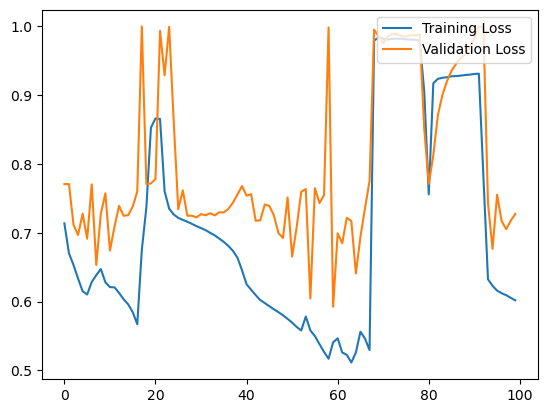

In [99]:
plt.plot(np.arange(100), train_loss, label='Training Loss')
plt.plot(np.arange(100), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.show()

In [89]:
model.load_state_dict(torch.load('./models/R2UNet_Dice_10.npz'))

<All keys matched successfully>

tensor(0.7729, device='cuda:0', grad_fn=<RsubBackward1>)

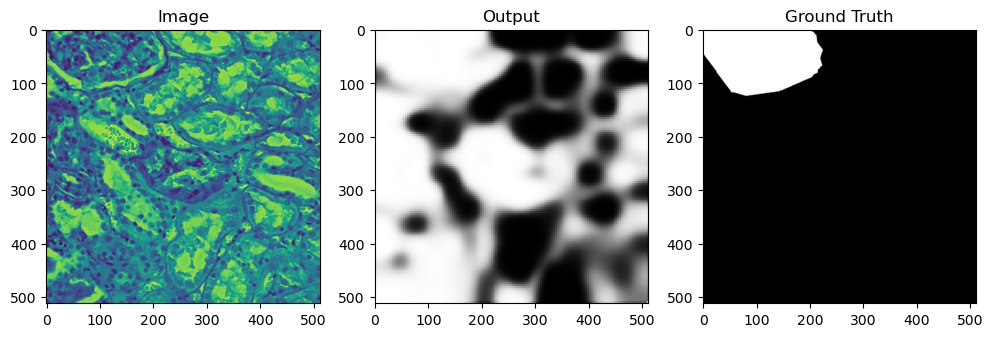

In [104]:
ID = 0
dataset = val_dataset

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')


dice_loss(out, torch.tensor([dataset[ID][1]]).type(dtype))

tensor(0.2523, device='cuda:0', grad_fn=<RsubBackward1>)

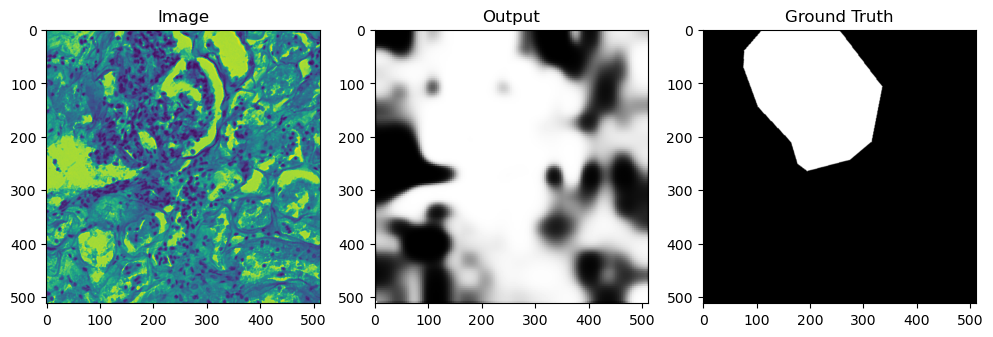

In [103]:
ID = 60
dataset = val_dataset

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')

dice_loss(out, torch.tensor([dataset[ID][0]]).type(dtype))

Text(0.5, 1.0, 'Ground Truth')

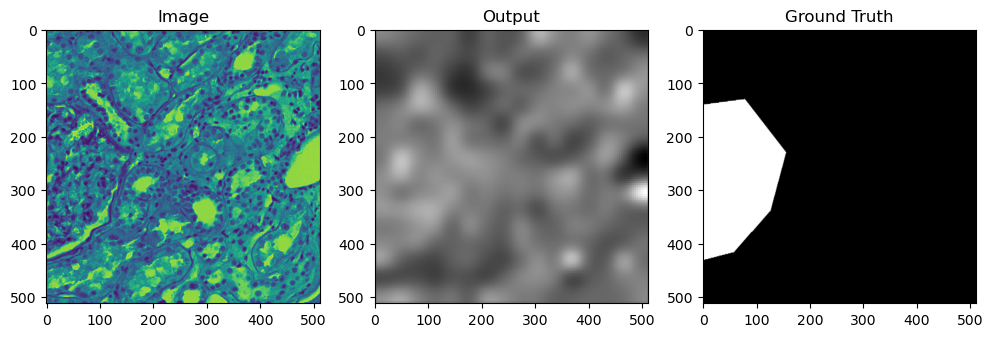

In [34]:
ID = 71
dataset = val_dataset

out = model.forward(torch.tensor([dataset[ID][0]]).type(dtype))
f, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(np.transpose(dataset[ID][0], (1, 2, 0)))
axes[1].imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)), cmap='gray')
axes[2].imshow(np.transpose(dataset[ID][1], (1, 2, 0)), cmap='gray')
axes[0].set_title('Image')
axes[1].set_title('Output')
axes[2].set_title('Ground Truth')